In [121]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import swan_vis as swan
from scipy import sparse

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

## Intron chain, TSS, TES triplet analysis

In [139]:
# get list of detected filtered isoforms
sg = swan.read('../swan/swan.p')
df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')
t_df, regions, counts = get_ic_tss_tes(sg,
                                         df,
                                         min_tpm=1, 
                                         gene_subset='polya',
                                         annot_slack=200,
                                         novel_slack=100)

Read in graph from ../swan/swan.p
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 185293
# isos >= 1 tpm: 167378
Applying gene type and novelty subset
Number of isos reported: 106687


In [140]:
t_df_back = t_df.copy(deep=True)

In [141]:
# get the gene-level ID for each transcript
t_df = t_df_back.copy(deep=True)
t_df = t_df.sort_values(by='annotation', ascending=False)

def get_gene_number(df, col, pref):
    new_col = '{}_gene_num'.format(pref)
    temp = df[['gid', col, 'annotation']].copy(deep=True)
    temp.drop_duplicates(subset=['gid', col], inplace=True)
    temp[new_col] = temp.sort_values(['gid', col, 'annotation'], 
                                 ascending=[True, True, False])\
                                 .groupby(['gid'])\
                                 .cumcount() + 1
    temp.drop('annotation', axis=1, inplace=True)
    df = df.merge(temp, how='left', on=['gid', col])
    return df

# tss 
print(t_df.head())
print()
t_df = get_gene_number(t_df, 'tss_cluster', 'tss')
print(t_df.head())
print()
t_df = get_gene_number(t_df, 'tes_cluster', 'tes')
print(t_df.head())
print()
t_df = get_gene_number(t_df, 'intron_chain', 'intron_chain')      

                 tname                 gid       gname  \
119970       DHX36-209  ENSG00000174953.13       DHX36   
159965  AL136295.1-201   ENSG00000254692.1  AL136295.1   
159953      CHI3L2-216  ENSG00000064886.13      CHI3L2   
159954       PARP2-207  ENSG00000129484.13       PARP2   
159955      MTFR1L-221  ENSG00000117640.17      MTFR1L   

                                                     path                tid  \
119970  [205726, 205685, 205686, 205687, 205688, 20568...  ENST00000481332.1   
159965  [625787, 625788, 625789, 625790, 625791, 62579...  ENST00000530611.1   
159953                              [45785, 45742, 45786]  ENST00000530597.1   
159954  [620871, 620837, 620838, 620839, 620840, 62084...  ENST00000530598.2   
159955  [15214, 15215, 15133, 15202, 15203, 15204, 151...  ENST00000530599.5   

                                                 loc_path  annotation novelty  \
119970  [669140, 669139, 669138, 669137, 669136, 66913...        True   Known   
159965  

In [142]:
def check_gene(df, counts, gname):
    print(t_df.loc[t_df.gname == gname, 'tss_gene_num'].max())
    print(t_df.loc[t_df.gname == gname, 'tes_gene_num'].max())
    print(t_df.loc[t_df.gname == gname, 'intron_chain_gene_num'].max())
    print()
    print(len(t_df.loc[t_df.gname == gname, 'tss_cluster'].unique().tolist()))
    print(len(t_df.loc[t_df.gname == gname, 'tes_cluster'].unique().tolist()))
    print(len(t_df.loc[t_df.gname == gname, 'intron_chain'].unique().tolist()))
    print()
    print(counts.loc[(counts.gname == gname)&(counts.source=='all')])

In [143]:
t_df.loc[t_df.tes_gene_num.isnull()]

Empty DataFrame
Columns: [tname, gid, gname, path, tid, loc_path, annotation, novelty, intron_chain, tss, tes, first_sd, tss_chrom, tss_coord, tes_chrom, tes_coord, tss_cluster, tss_annotation, tes_cluster, tes_annotation, tss_gene_num, tes_gene_num, intron_chain_gene_num]
Index: []

[0 rows x 23 columns]

In [144]:
# check_gene(t_df, counts, 'COL1A1')
check_gene(t_df, counts, 'ELN')

7
13
158

7
13
158

         tss  intron_chain  tes  tss_ic_tes  splicing_ratio source  \
21978.0    7           158   13         158            15.8    all   

                        gid gname         biotype biotype_category     tf  
21978.0  ENSG00000049540.16   ELN  protein_coding   protein_coding  False  


In [145]:
# col = 'tss_cluster'
# pref = 'tss'
# temp = t_df.loc[t_df.gid == 'ENSG00000044115.20']
# new_col = '{}_gene_num'.format(pref)
# print(temp.head())
# temp.sort_values(['gid', col, 'annotation'], 
#                              ascending=[True, True, False]).groupby(['gid']).cumcount()+ 1

In [146]:
t_df['ttrip'] = t_df.gname +' ('+\
                t_df.tss_gene_num.astype('str')+','+\
                t_df.intron_chain_gene_num.astype('str')+','+\
                t_df.tes_gene_num.astype('str')+')'
  

In [147]:
t_df.ttrip.head()

0         DHX36 (4,8,7)
1    AL136295.1 (1,1,1)
2        CHI3L2 (6,5,1)
3         PARP2 (6,9,6)
4       MTFR1L (7,30,3)
Name: ttrip, dtype: object

In [102]:
temp = t_df.loc[t_df.gname == 'MEF2C', ['tss_cluster', 'tss_gene_num']].drop_duplicates()
temp.loc[temp.tss_cluster.duplicated(keep=False)]
t_df.loc[t_df.tss_cluster == 35866]

tname                 gid  gname  \
48248           MEF2C-220  ENSG00000081189.15  MEF2C   
45109           MEF2C-221  ENSG00000081189.15  MEF2C   
89116           MEF2C-256  ENSG00000081189.15  MEF2C   
89764           MEF2C-249  ENSG00000081189.15  MEF2C   
59755           MEF2C-213  ENSG00000081189.15  MEF2C   
53581           MEF2C-210  ENSG00000081189.15  MEF2C   
57214           MEF2C-217  ENSG00000081189.15  MEF2C   
56754           MEF2C-215  ENSG00000081189.15  MEF2C   
57579           MEF2C-219  ENSG00000081189.15  MEF2C   
54943           MEF2C-206  ENSG00000081189.15  MEF2C   
219371  ENCODEHT000458453  ENSG00000081189.15  MEF2C   
219722  ENCODEHT000458385  ENSG00000081189.15  MEF2C   

                                                     path                tid  \
48248   [273403, 273312, 273313, 273314, 273315, 27334...  ENST00000513252.5   
45109   [273372, 273312, 273313, 273314, 273315, 27331...  ENST00000514015.5   
89116                            [273470, 273471, 273472]  ENST00000637801.1   
89764   [273344, 273345, 273346, 273314, 273315, 27331...  ENST00000637481.1   
59755   [273384, 273312, 273313, 273314, 273315, 27331...  ENST00000508569.5   
53581   [273366, 273312, 273313, 273314, 273315, 27331...  ENST00000506554.5   
57214   [273344, 273345, 273346, 273314, 273315, 27331...  ENST00000510942.5   
56754            [273372, 273460, 273461, 273462, 273463]  ENST00000509349.1   
57579            [273448, 273345, 273346, 273314, 273449]  ENST00000511086.1   
54943   [273434, 273435, 273436, 273437, 273346, 27331...  ENST00000503075.1   
219371  [964462, 273345, 273346, 273314, 273315, 27331...  ENCODEHT000458453   
219722  [964462, 273312, 273313, 273314, 273315, 27331...  ENCODEHT000458385   

                                                 loc_path  annotation novelty  \
48248   [738405, 738400, 738370, 738362, 738359, 73835...        True   Known   
45109   [738411, 738400, 738370, 738362, 738359, 73835...        True   Known   
89116                    [738402, 738400, 738394, 738391]        True   Known   
89764   [738410, 738400, 738369, 738362, 738359, 73835...        True   Known   
59755   [738408, 738400, 738370, 738362, 738359, 73835...        True   Known   
53581   [738406, 738400, 738370, 738362, 738359, 73835...        True   Known   
57214   [738410, 738400, 738369, 738362, 738359, 73835...        True   Known   
56754    [738411, 738400, 738388, 738387, 738369, 738366]        True   Known   
57579    [738407, 738400, 738369, 738362, 738359, 738352]        True   Known   
54943   [738412, 738400, 738398, 738396, 738369, 73836...        True   Known   
219371  [738409, 738400, 738369, 738362, 738359, 73835...       False     NIC   
219722  [738409, 738400, 738370, 738362, 738359, 73835...       False     NIC   

                                             intron_chain     tss  ...  \
48248   (273312, 273313, 273314, 273315, 273343, 27333...  738405  ...   
45109   (273312, 273313, 273314, 273315, 273316, 27331...  738411  ...   
89116                                           (273471,)  738402  ...   
89764   (273345, 273346, 273314, 273315, 273316, 27331...  738410  ...   
59755   (273312, 273313, 273314, 273315, 273316, 27331...  738408  ...   
53581   (273312, 273313, 273314, 273315, 273316, 27331...  738406  ...   
57214   (273345, 273346, 273314, 273315, 273316, 27331...  738410  ...   
56754                            (273460, 273461, 273462)  738411  ...   
57579                            (273345, 273346, 273314)  738407  ...   
54943   (273435, 273436, 273437, 273346, 273314, 27331...  738412  ...   
219371  (273345, 273346, 273314, 273315, 273316, 27331...  738409  ...   
219722  (273312, 273313, 273314, 273315, 273316, 27331...  738409  ...   

        tss_coord  tes_chrom tes_coord  tss_cluster tss_annotation  \
48248    88883147       chr5  88731805        35866           True   
45109    88883224       chr5  88721570        35866           True   
89116    88882996      

In [45]:
# add triplets for samples
df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')
temp = compute_triplets(t_df,
                        df,
                        min_tpm=1,
                        groupby='sample')
counts = pd.concat([counts, temp])

# add tpm on the sample level to the table
df = pd.read_csv('../talon/human_talon_abundance.tsv', sep='\t')
gene_df,_ = get_tpm_table(df,
                         how='gene',
                         min_tpm=1, 
                         gene_subset='polya',
                         groupby='sample')
gene_df = gene_df.melt(ignore_index=False)
gene_df.rename({'value':'tpm'}, axis=1, inplace=True)
gene_df.reset_index(inplace=True)
gene_df.rename({'index': 'gid'}, axis=1, inplace=True)
counts = counts.merge(gene_df, how='left', left_on=['source', 'gid'], right_on=['biosample', 'gid'])

In [11]:
# save all observed triplets
temp = counts.loc[counts.source == 'obs']
temp.to_csv('obs_triplets.tsv', sep='\t', index=False)

In [12]:
# save triplets
counts.to_csv('triplets.tsv', sep='\t', index=False)

## Plotting

In [2]:
c_dict, order = get_biosample_colors()
c_dict['GENCODE'] = 'k'
c_dict['obs'] = 'k'
counts = pd.read_csv('triplets.tsv', sep='\t')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


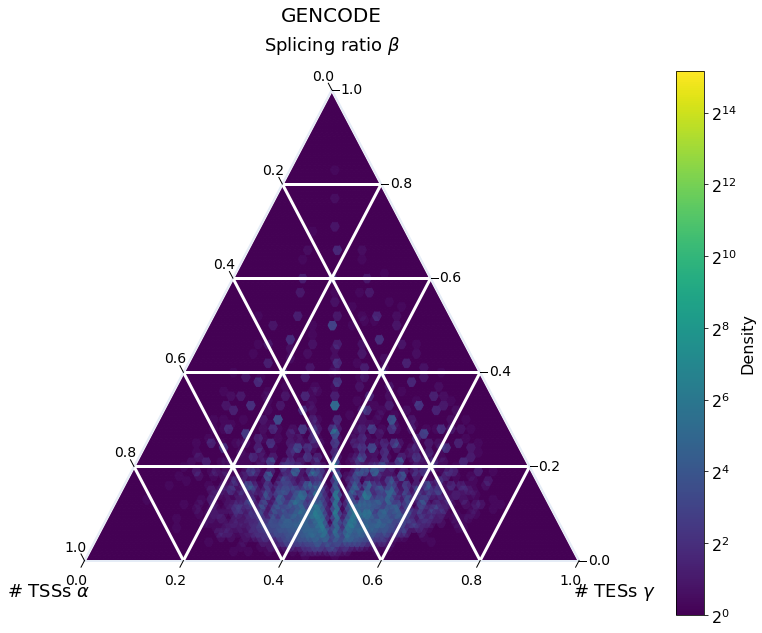

In [16]:
# gencode
temp = plot_dorito(counts,
            top='splicing_ratio',
            subset={'source': 'GENCODE'},
            density=True,
            density_scale=100,
            log_density=True,
            scatter=False,
            title='GENCODE',
            opref='figures/human')

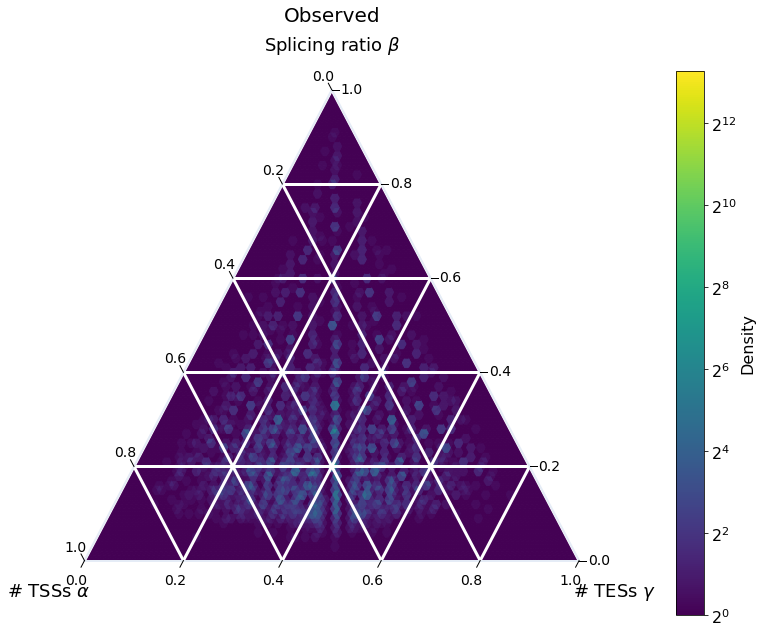

In [17]:
# observed
temp = plot_dorito(counts,
            top='splicing_ratio',
            subset={'source': 'obs'},
            density=True,
            density_scale=100,
            log_density=True,
            scatter=False,
            title='Observed',
            opref='figures/human')

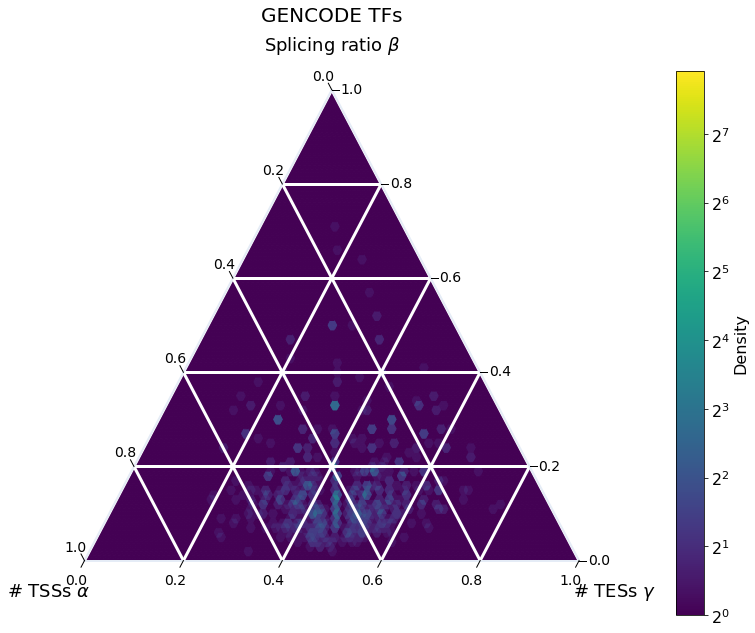

In [19]:
# all tfs in gencode
temp = plot_dorito(counts,
                top='splicing_ratio',
                # hue='intron_chain',
                scatter=False,
                subset={'source': 'GENCODE', 'tf': True},
                jitter=True,
                density=True,
                density_scale=100,
                log_density=True,
                title='GENCODE TFs',
                opref='figures/human')

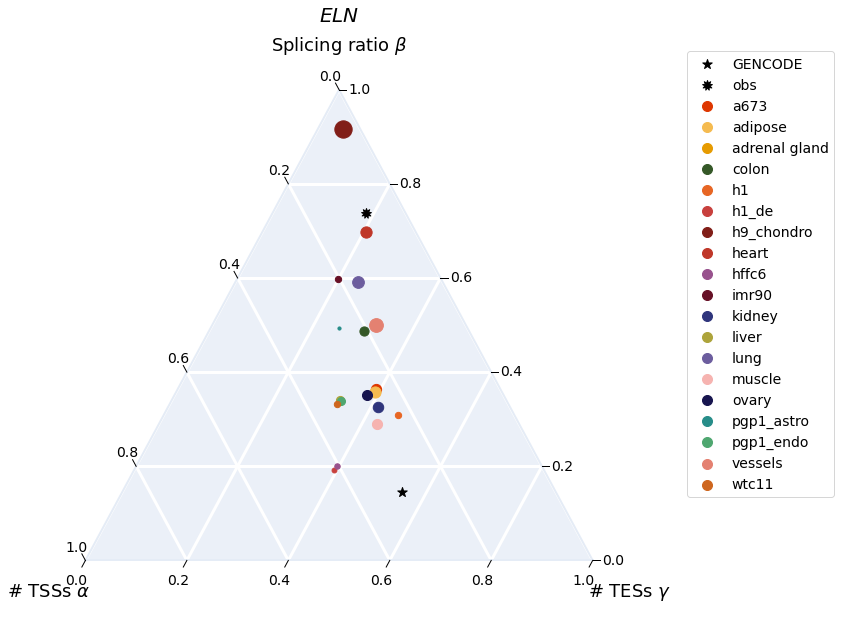

In [23]:
# ELN
_ = plot_dorito(counts,
            top='splicing_ratio', 
            gene='ELN',
            hue='source',
            size='tpm', 
            log_size=True,
            cmap=c_dict,
            mmap={'GENCODE': '*', 'obs': (9,1,0)},
            jitter=True,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all']))}, 
            opref='figures/human')

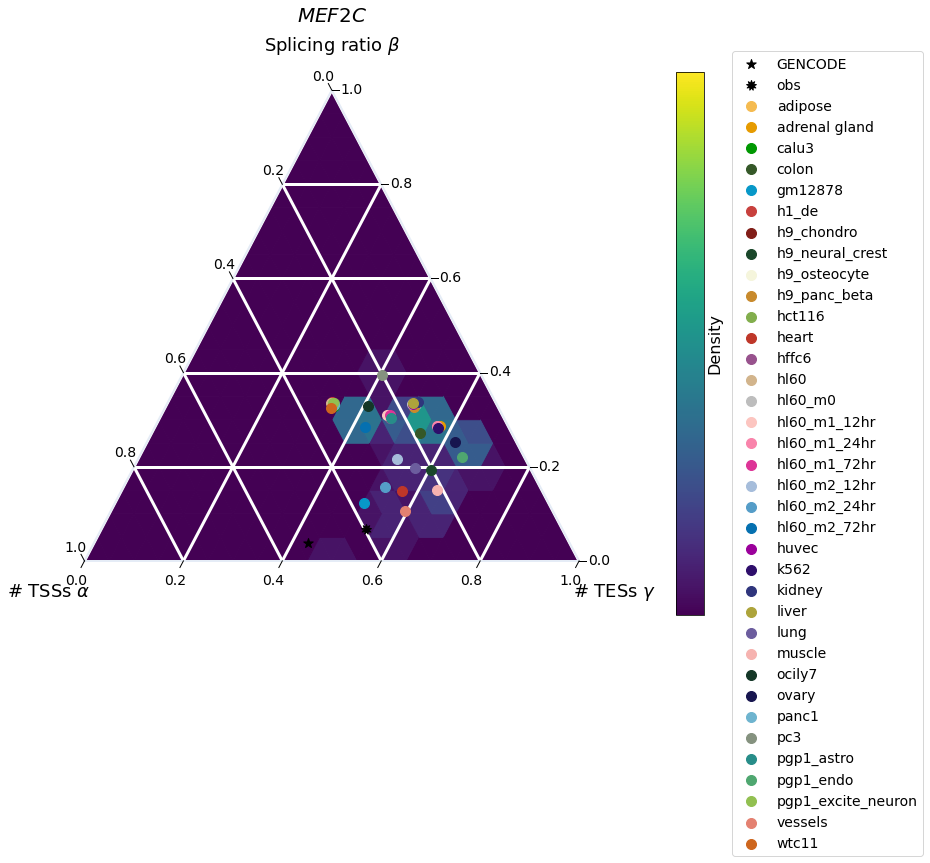

In [25]:
# MEF2C
_ = plot_dorito(counts,
            top='splicing_ratio', 
            gene='MEF2C',
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*', 'obs': (9,1,0)},
            jitter=True,
            density=True,
            density_scale=20,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all']))}, 
            opref='figures/human')

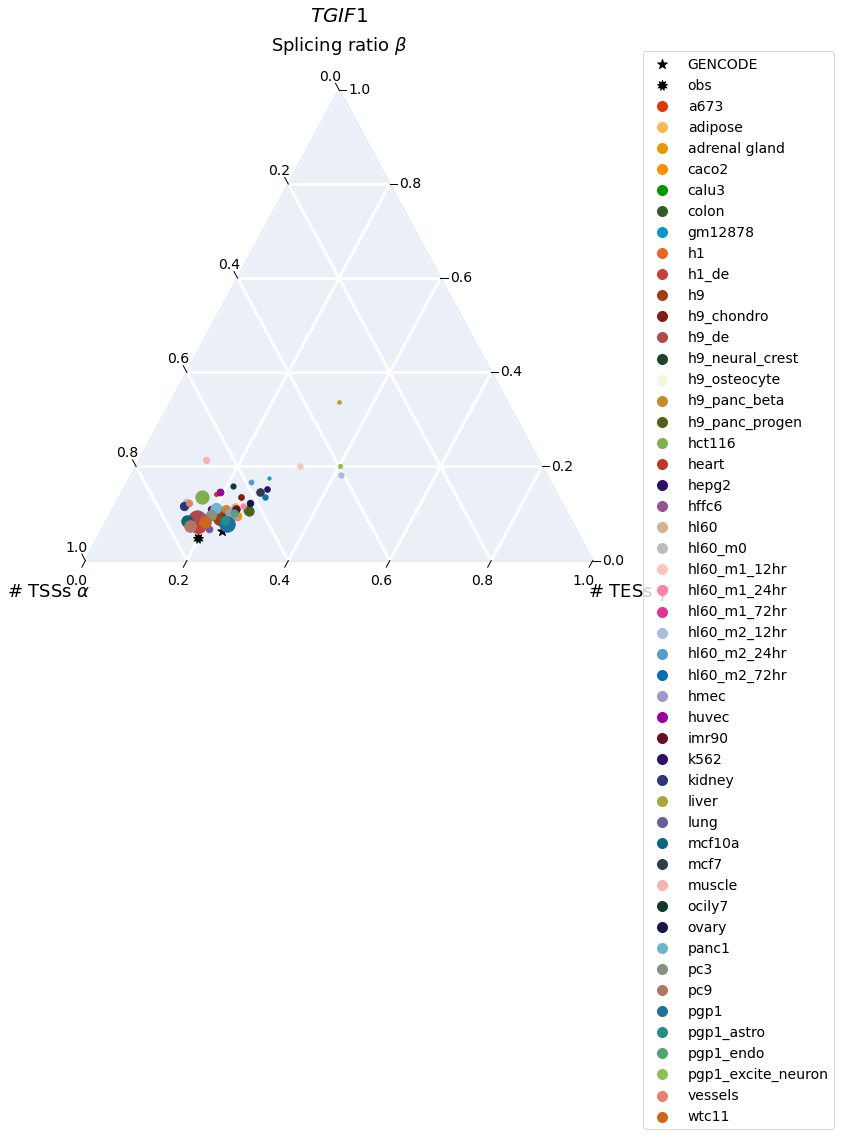

In [4]:
# TGIF1
_ = plot_dorito(counts,
            top='splicing_ratio', 
            gene='TGIF1',
            size='tpm', 
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*', 'obs': (9,1,0)},
            jitter=True,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all']))},
            opref='figures/human')

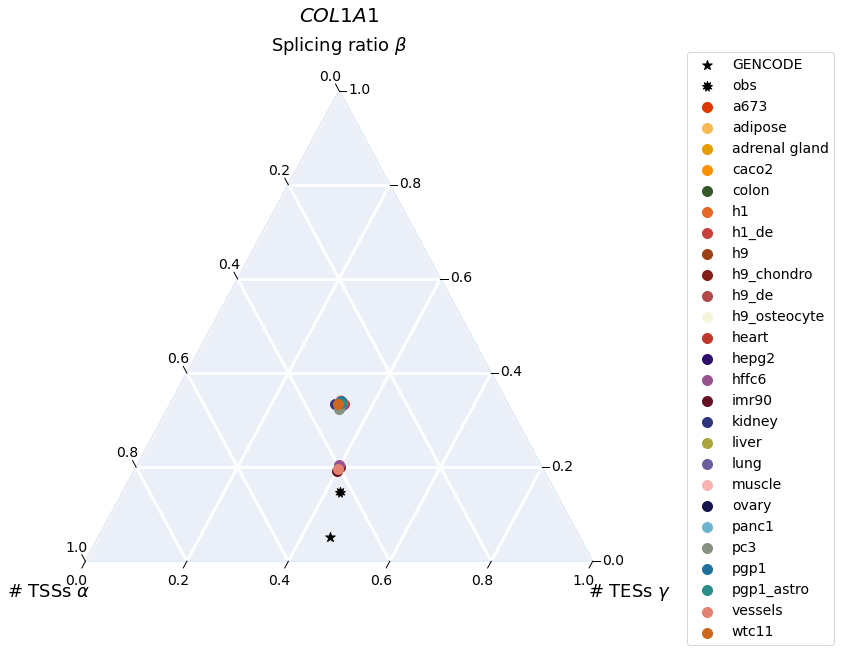

In [5]:
# COL1A1
_ = plot_dorito(counts,
            top='splicing_ratio', 
            gene='COL1A1',
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*', 'obs': (9,1,0)},
            jitter=True,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all']))},
            opref='figures/human')

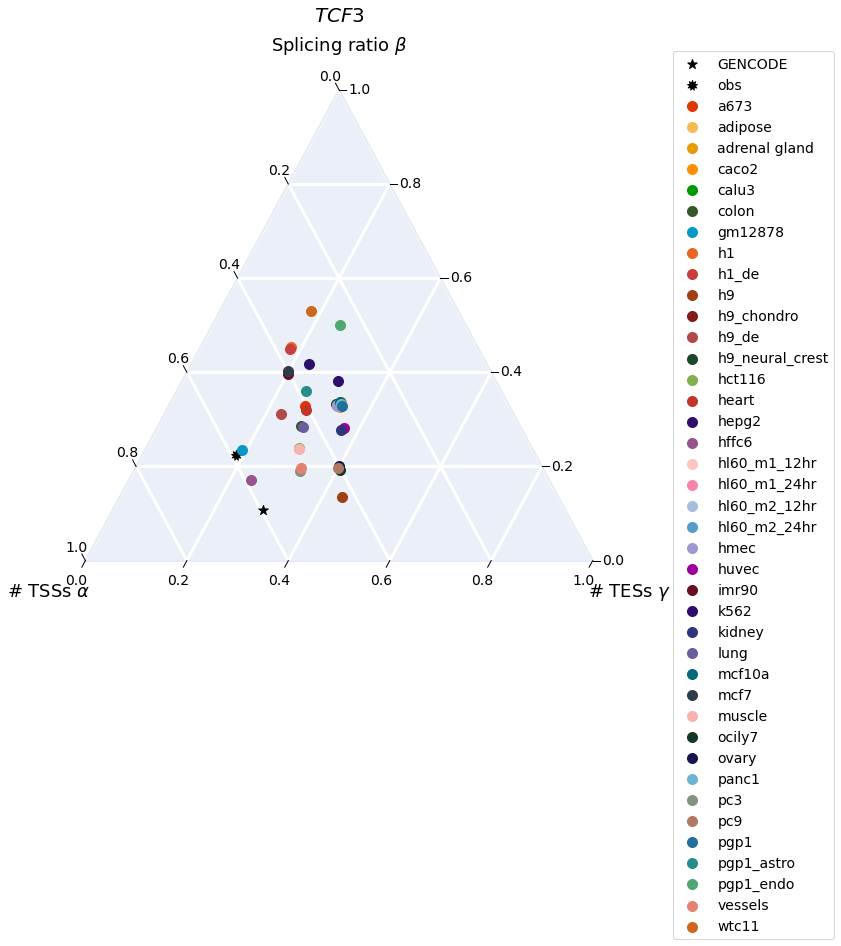

In [6]:
# TCF3
_ = plot_dorito(counts,
            top='splicing_ratio', 
            gene='TCF3',
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*', 'obs': (9,1,0)},
            jitter=True,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all']))},)

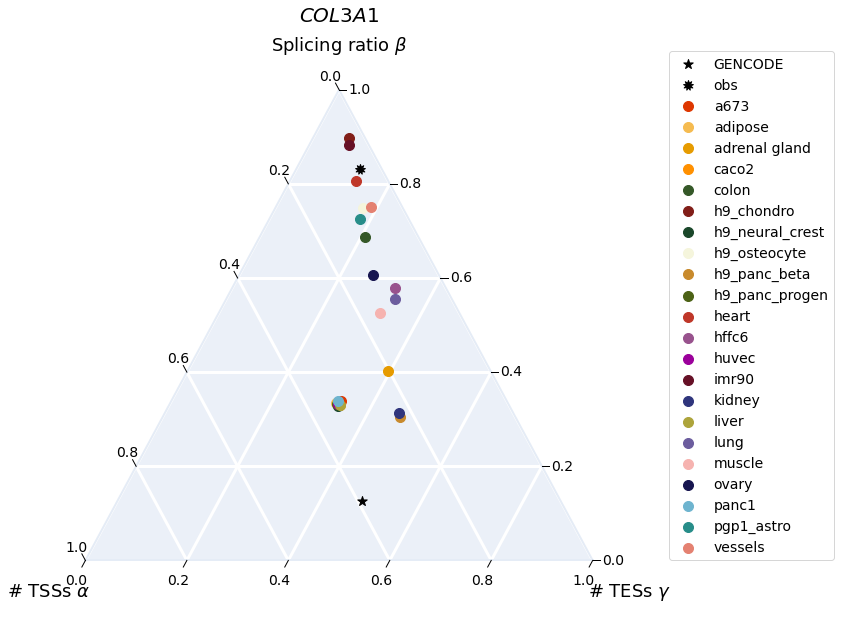

In [7]:
# COL3A1
c_dict = c_dict
c_dict['GENCODE'] = 'k'
_ = plot_dorito(counts,
            top='splicing_ratio', 
            gene='COL3A1',
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*', 'obs': (9,1,0)},
            jitter=True,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all']))},)

In [8]:
counts.loc[(counts.gname == 'COL3A1')&(counts.source=='obs')]
counts.loc[counts.gname == 'COL3A1']

tss  intron_chain  tes  tss_ic_tes  splicing_ratio           source  \
12388     4             6    5           6        1.333333          GENCODE   
71168     4            43    5          43        9.555556              all   
129110    1            39    3          39       19.500000              obs   
150384    1             1    1           1        1.000000             a673   
160773    1             1    1           1        1.000000          adipose   
172783    1             3    2           3        2.000000    adrenal gland   
185838    1             1    1           1        1.000000            caco2   
211062    1            10    2          10        6.666667            colon   
277215    1            38    2          38       25.333333       h9_chondro   
299333    1             1    1           1        1.000000  h9_neural_crest   
309763    1            13    2          13        8.666667     h9_osteocyte   
319886    1             2    2           2        1.333333     h9_panc_beta   
330647    1             1    1           1        1.000000   h9_panc_progen   
355099    1            18    2          18       12.000000            heart   
382330    1            11    3          11        5.500000            hffc6   
484095    1             1    1           1        1.000000            huvec   
495365    1            32    2          32       21.333333            imr90   
520219    1             2    2           2        1.333333           kidney   
532343    1             1    1           1        1.000000            liver   
545416    1            10    3          10        5.000000             lung   
581857    1             5    2           5        3.333333           muscle   
605133    1             7    2           7        4.666667            ovary   
617429    1             1    1           1        1.000000            panc1   
665072    1            12    2          12        8.000000       pgp1_astro   
700999    1            24    3          24       12.000000          vessels   

                       gid   gname         biotype biotype_category     tf  \
12388   ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
71168   ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
129110  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
150384  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
160773  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
172783  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
185838  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
211062  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
277215  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
299333  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
309763  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
319886  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
330647  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
355099  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
382330  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
484095  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
495365  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
520219  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
532343  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
545416  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
581857  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
605133  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
617429  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
665072  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
700

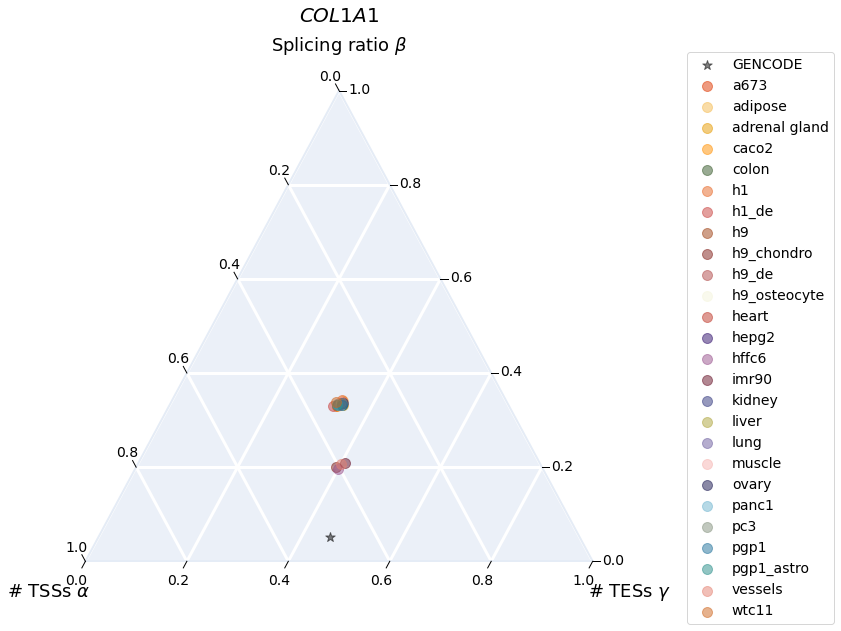

In [9]:
# COL1A1
temp = plot_dorito(counts,
            top='splicing_ratio', 
            gene='COL1A1',
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*'},
            jitter=True,
            alpha=0.5,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all', 'obs']))})

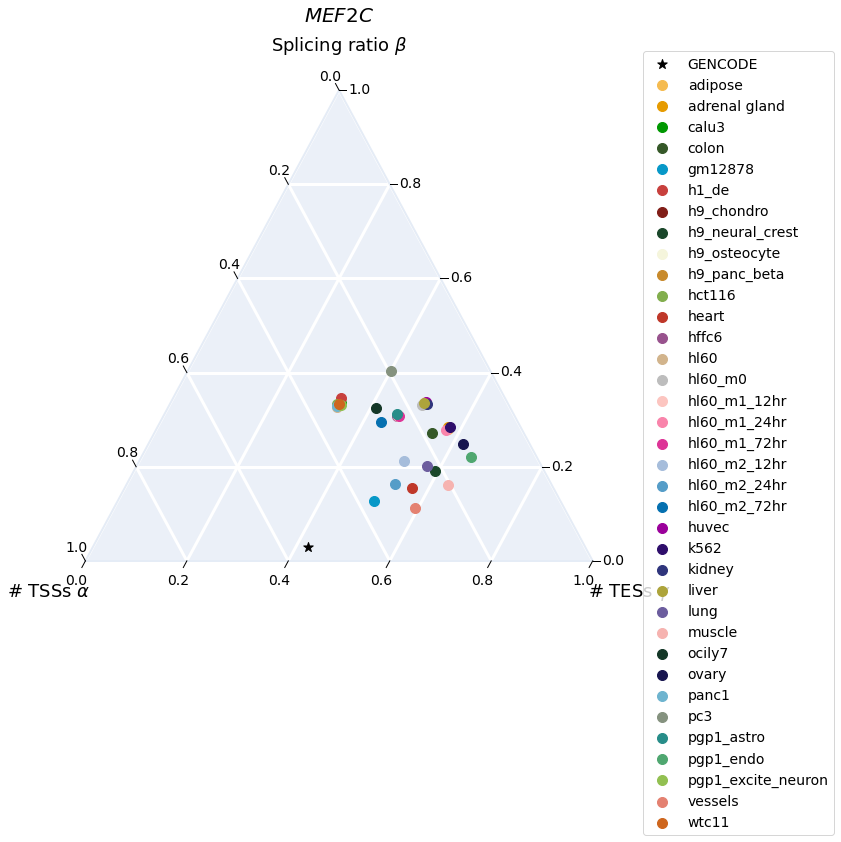

In [10]:
# MEF2C
temp = plot_dorito(counts,
            top='splicing_ratio', 
            gene='MEF2C',
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*'},
            jitter=True,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all', 'obs']))})

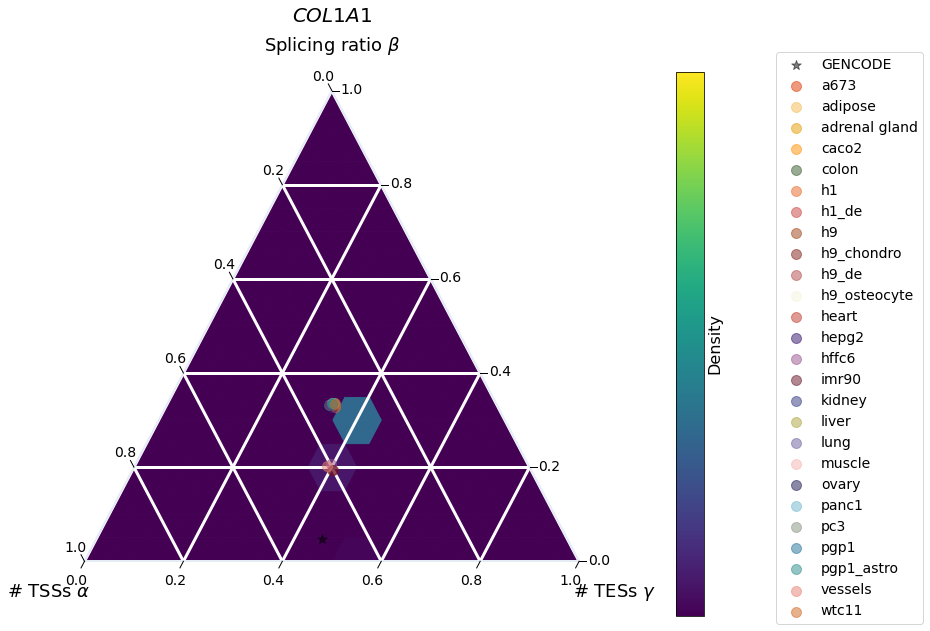

In [11]:
# COL1A1
c_dict = c_dict
c_dict['GENCODE'] = 'k'
temp = plot_dorito(counts,
            top='splicing_ratio', 
            gene='COL1A1',
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*'},
            density=True,
            density_scale=20,
            jitter=True,
            alpha=0.5,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all', 'obs']))})

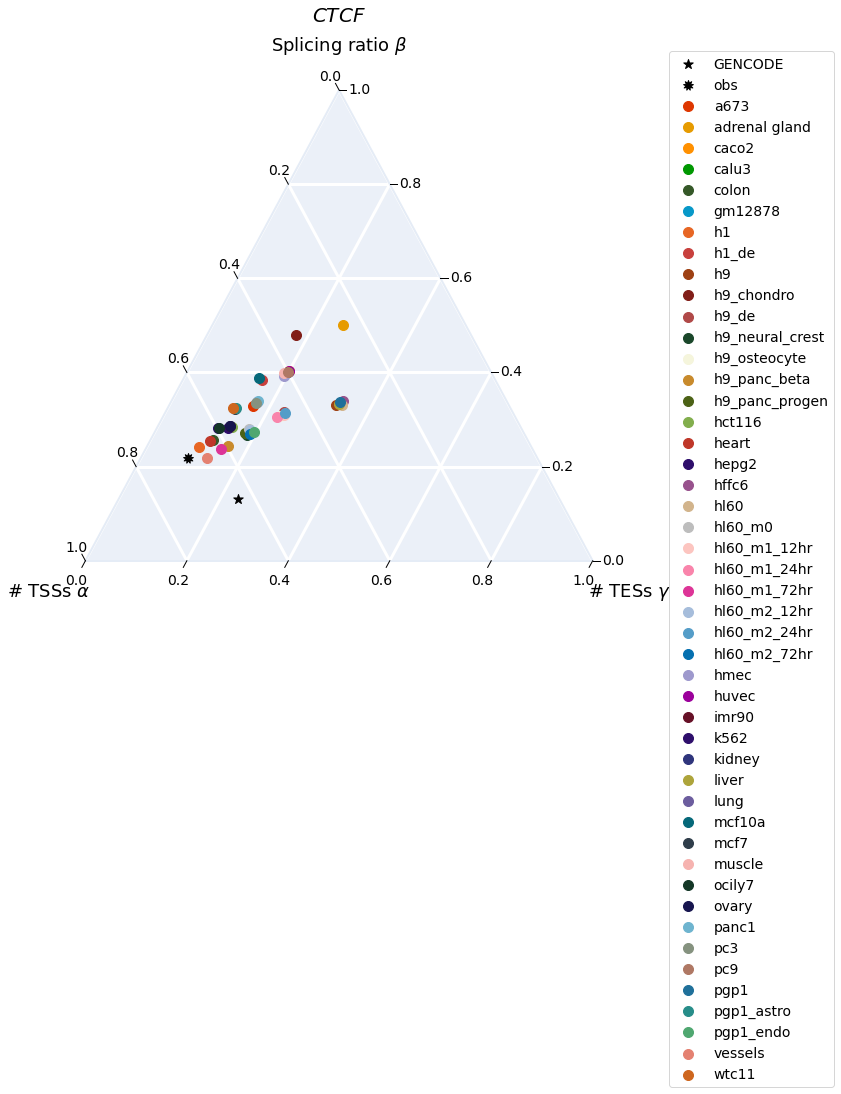

In [12]:
# CTCF
temp = plot_dorito(counts,
            top='splicing_ratio', 
            gene='CTCF',
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*', 'obs': (9,1,0)},
            jitter=True,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all']))},)

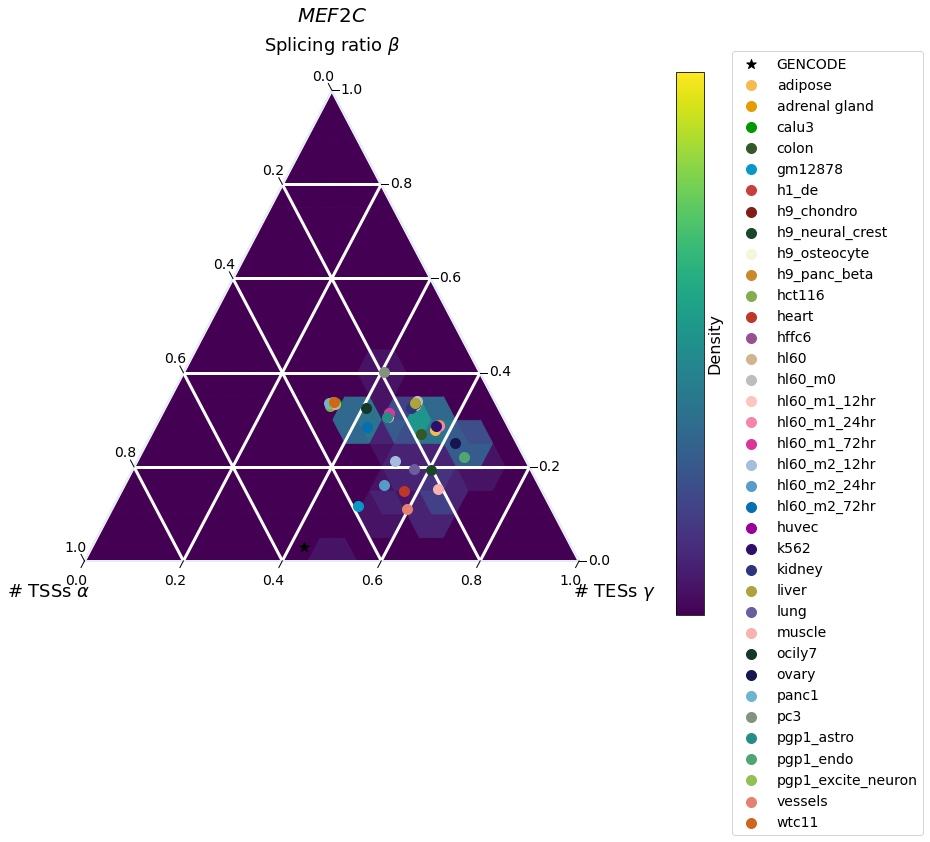

In [14]:
# MEF2C
temp = plot_dorito(counts,
            top='splicing_ratio', 
            gene='MEF2C',
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*'},
            jitter=True,
            density=True,
            density_scale=20,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all', 'obs']))})

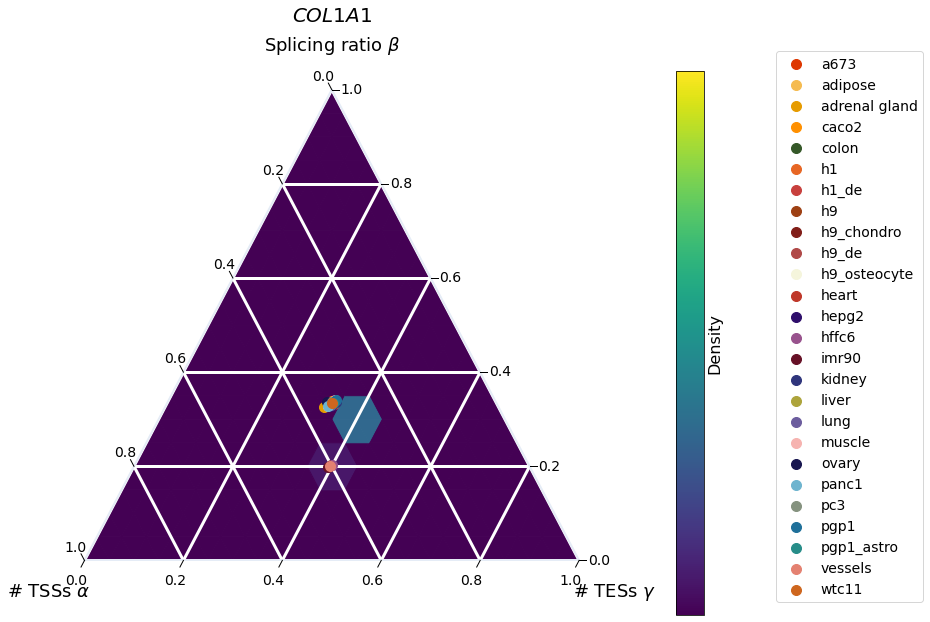

In [15]:
# COL1A1
temp = plot_dorito(counts,
            top='splicing_ratio', 
            gene='COL1A1',
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*'},
            jitter=True,
            density=True,
            density_scale=20,
            subset={'source':list(set(counts.source.unique().tolist())-set(['GENCODE', 'all', 'obs']))})

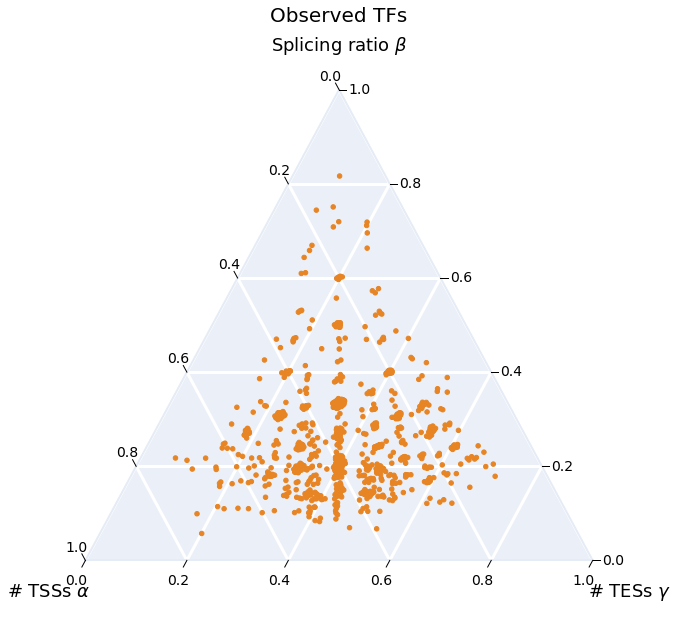

In [16]:
# all tfs in observed example
temp = plot_dorito(counts,
            top='splicing_ratio',
            # hue='intron_chain',
            # density=True, 
            # density_scale=20,
            jitter=True,
            subset={'source': 'obs', 'tf': True},
            title='Observed TFs')

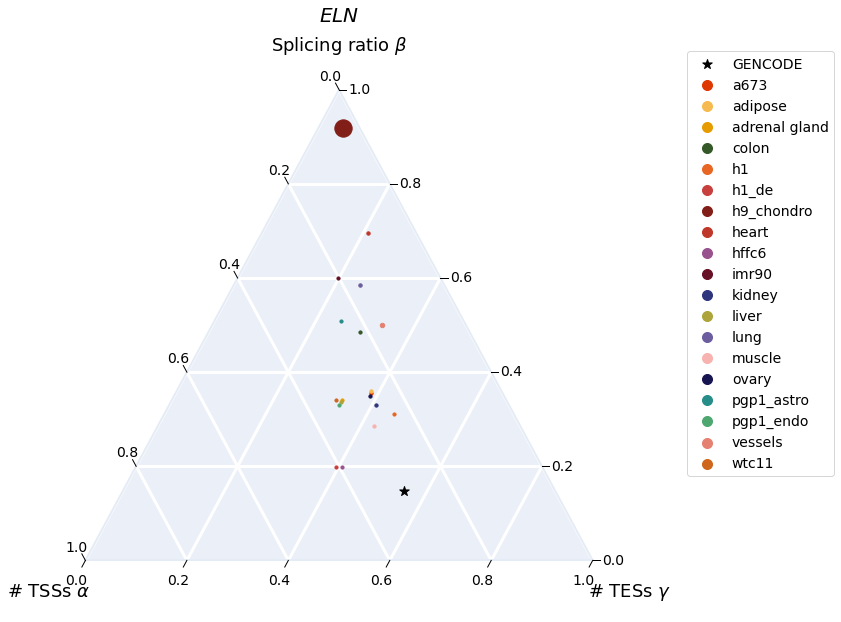

In [18]:
# ELN
temp = plot_dorito(counts,
            top='splicing_ratio', 
            gene='ELN',
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*'},
            jitter=True,
            size='tpm',
            subset={'source':list(set(counts.source.unique().tolist())-set(['all', 'obs']))})

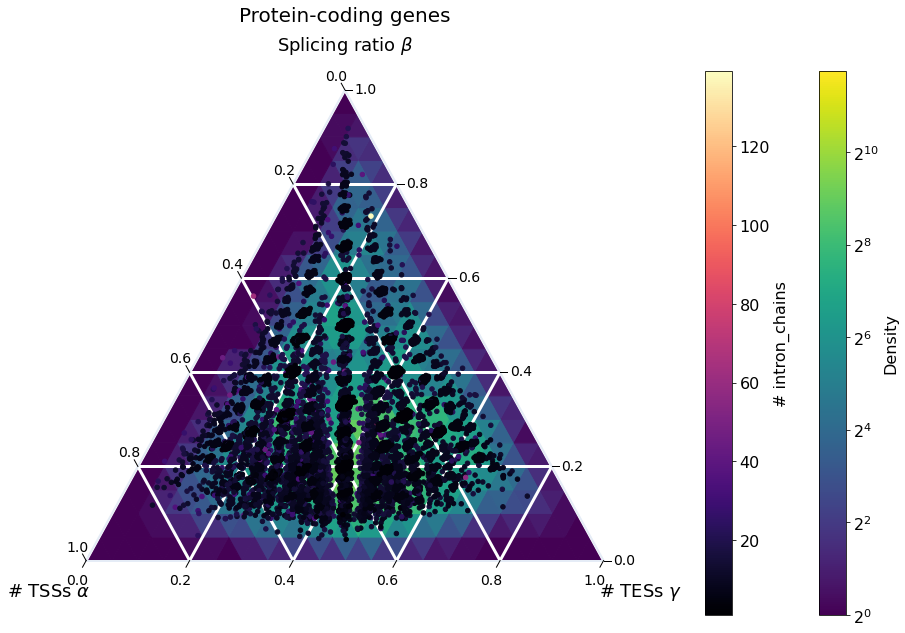

In [19]:
# all protein-coding genes in gencode example
_ = plot_dorito(counts,
            top='splicing_ratio',
            hue='intron_chain',
            density=True,
            density_scale=20,
            log_density=True,
            jitter=True,
            subset={'biotype': 'protein_coding', 'source': 'obs'},
            title='Protein-coding genes')

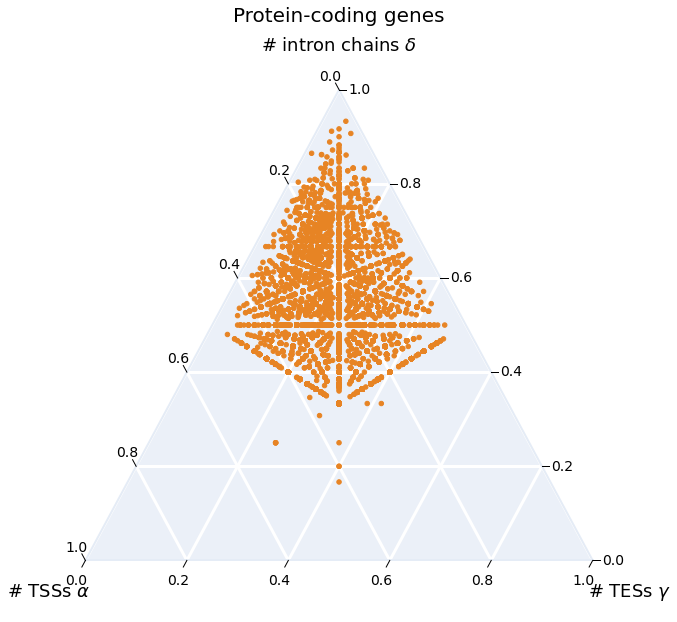

In [21]:
# all protein-coding genes in gencode example
_ = plot_dorito(counts,
            top='intron_chain',
            subset={'biotype': 'protein_coding', 'source': 'obs'},
            title='Protein-coding genes')

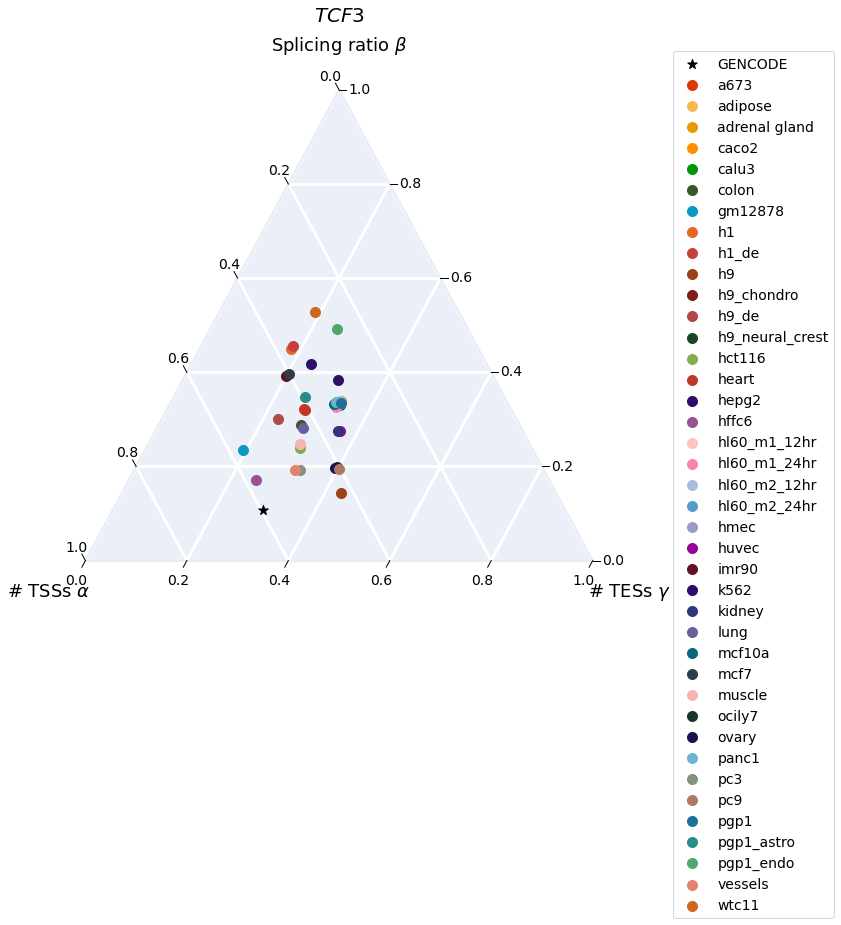

In [22]:
# gene example
_ = plot_dorito(counts,
            top='splicing_ratio', 
            gene='TCF3',
            hue='source',
            cmap=c_dict,
            jitter=True,
            mmap={'GENCODE': '*'},
            subset={'source':list(set(counts.source.unique().tolist())-set(['all', 'obs']))})

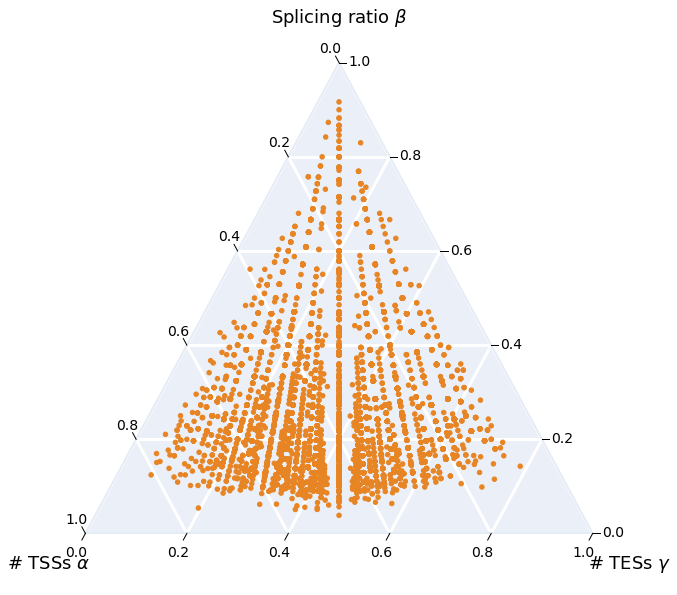

In [23]:
# obs example
_ = plot_dorito(counts,
            top='splicing_ratio',
            subset={'source': 'obs'})

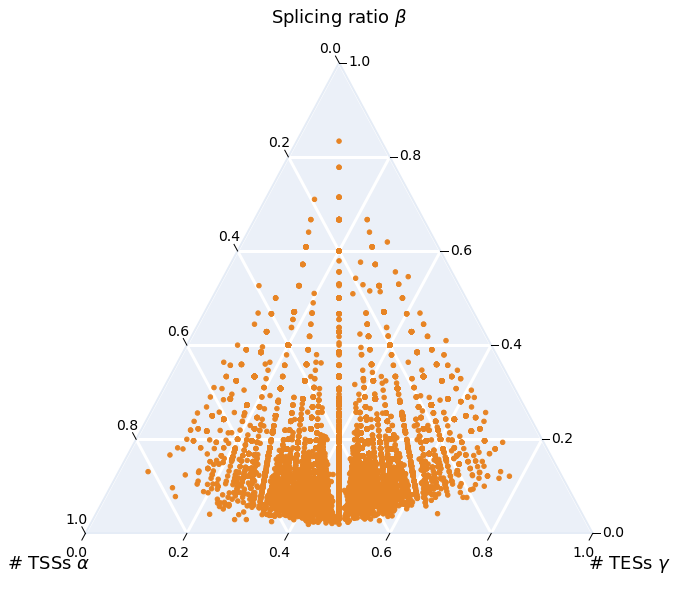

In [24]:
# gencode example
_ = plot_dorito(counts,
            top='splicing_ratio',
            subset={'source': 'GENCODE'})

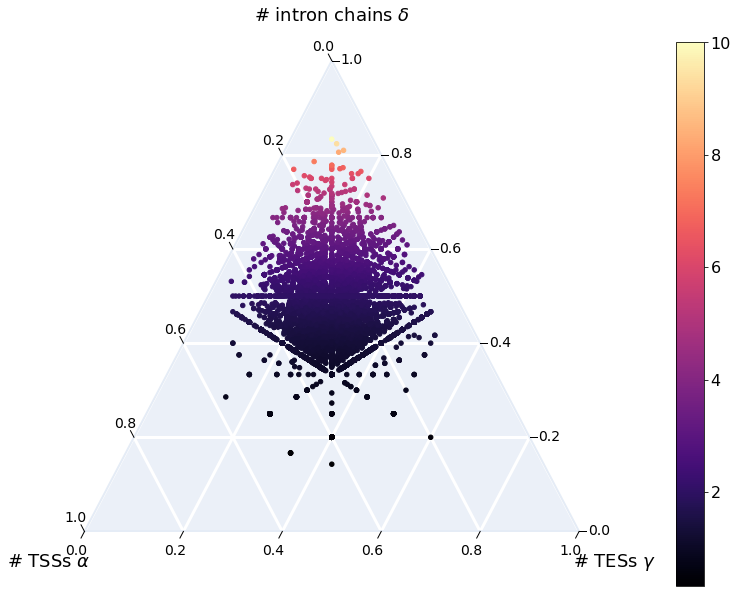

In [25]:
# gencode example - color by splicing ratio
_ = plot_dorito(counts,
            top='intron_chain',
            hue='splicing_ratio',
            subset={'source': 'GENCODE'})

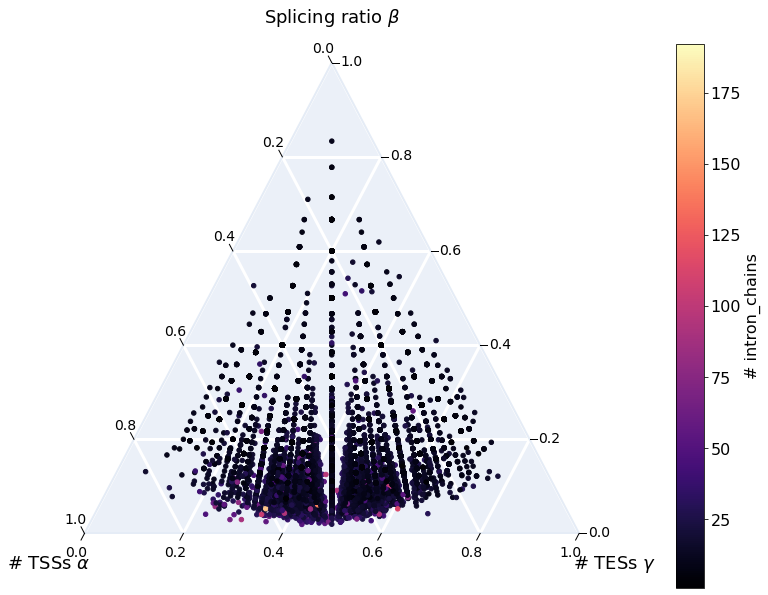

In [26]:
# gencode example - color by splicing ratio
_ = plot_dorito(counts,
            top='splicing_ratio',
            hue='intron_chain',
            subset={'source': 'GENCODE'})

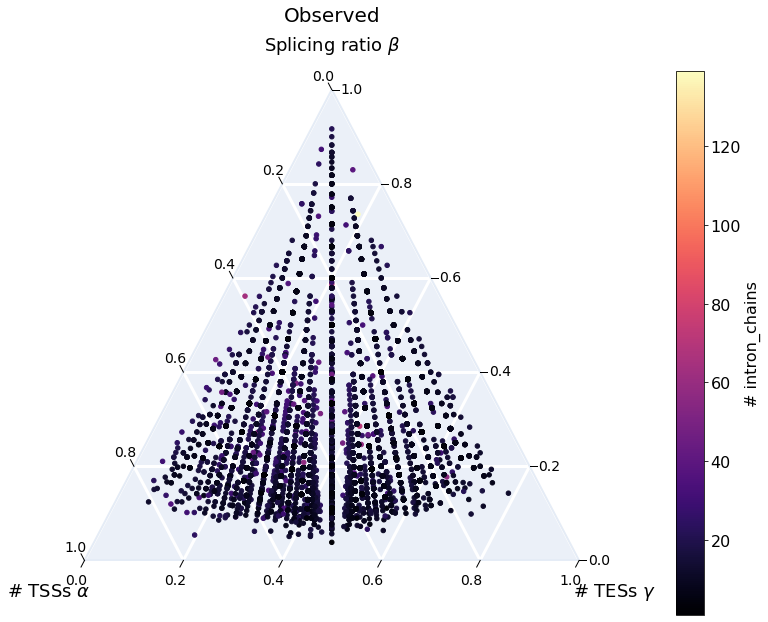

In [27]:
# observed example - color by n ic
_ = plot_dorito(counts,
            top='splicing_ratio',
            hue='intron_chain',
            subset={'source':'obs'},
            title='Observed')

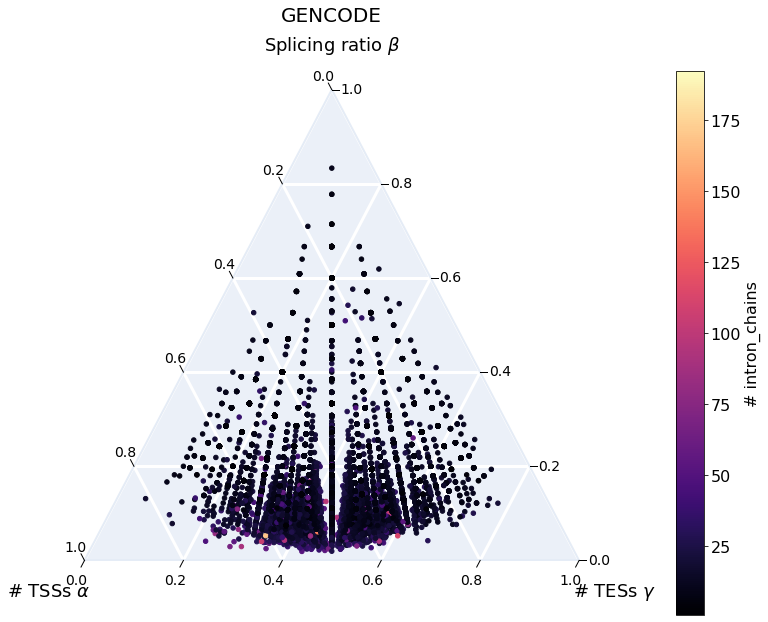

In [28]:
# gencode example - color by n ic
_ = plot_dorito(counts,
            top='splicing_ratio',
            hue='intron_chain',
            subset={'source':'GENCODE'},
            title='GENCODE')

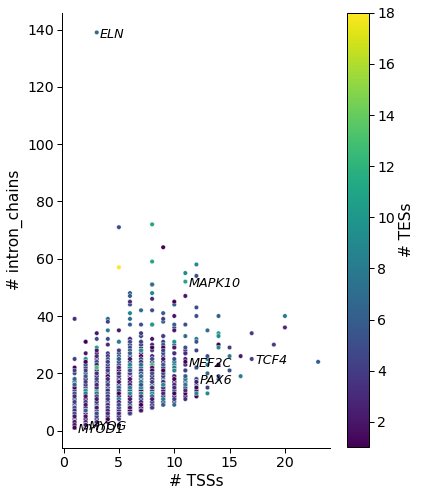

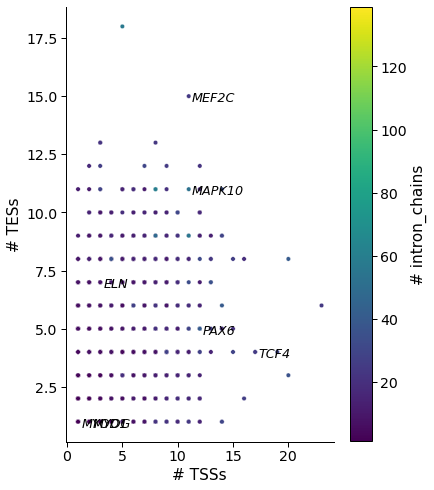

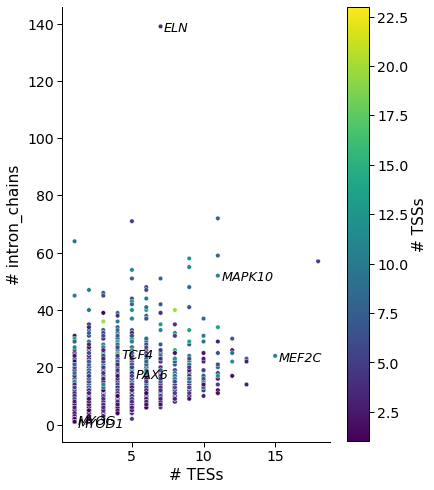

In [29]:
genes = ['PAX6', 'TCF4', 'MAPK10', 'ELN', 'MEF2C', 'MYOD1', 'MYOG']
plot_n_ic_tss_tes(counts.loc[counts.source=='obs'], 
                  label_genes=genes,
                  kind='obs',
                  opref='figures/human')

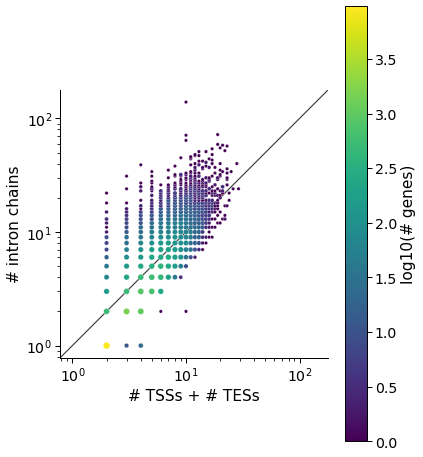

In [30]:
plot_genes_n_ic_ends(counts.loc[counts.source=='obs'], 
                     kind='obs', 
                     opref='figures/human')

In [31]:
# get list of detected filtered isoforms
sg = swan.read('../swan/swan.p')
df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')
t_df, regions, counts = get_ic_tss_tes(sg,
                                         df,
                                         min_tpm=1, 
                                         gene_subset='polya',
                                         annot_slack=200,
                                         novel_slack=100)

# add 90% set triplets
df = pd.read_csv('../swan/isos_sample_gene_90.tsv', sep='\t')
temp = compute_triplets(t_df,
                        df, 
                        groupby='sample')
counts = pd.concat([counts, temp])

# add tpm on the sample level to the table
df = pd.read_csv('../talon/human_talon_abundance.tsv', sep='\t')
gene_df,_ = get_tpm_table(df,
                         how='gene',
                         min_tpm=1, 
                         gene_subset='polya',
                         groupby='sample')
gene_df = gene_df.melt(ignore_index=False)
gene_df.rename({'value':'tpm'}, axis=1, inplace=True)
gene_df.reset_index(inplace=True)
gene_df.rename({'index': 'gid'}, axis=1, inplace=True)
counts = counts.merge(gene_df, how='left', left_on=['source', 'gid'], right_on=['biosample', 'gid'])

Read in graph from ../swan/swan.p
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 185293
# isos >= 1 tpm: 167378
Applying gene type and novelty subset
Number of isos reported: 106687
Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Enforcing minimum TPM
Total # genes detected: 559881
# genes >= 1 tpm: 274347
Applying gene type and novelty subset
Averaging over biosample
Found 49 total samples
Number of genes reported: 33635


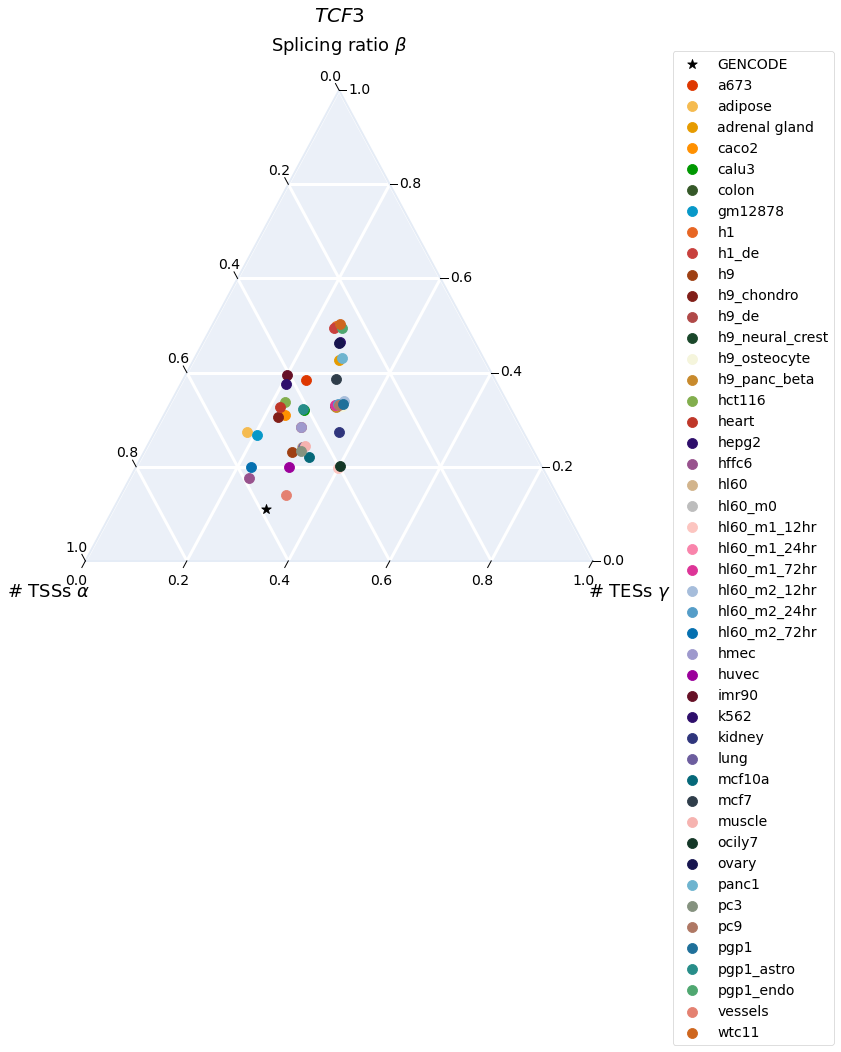

In [32]:
# gene example
_ = plot_dorito(counts,
            top='splicing_ratio', 
            gene='TCF3',
            hue='source',
            cmap=c_dict,
            jitter=True,
            mmap={'GENCODE': '*'},
            subset={'source':list(set(counts.source.unique().tolist())-set(['all', 'obs']))})